<a href="https://colab.research.google.com/github/GeremiaPompei/ISPR/blob/main/midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISP Midterm 1 - Assignment 6 - Pompei Geremia (MAT. 638432)

## Code
Initial part is composed by the commands that allow me to download the zip containing the dataset and extract from this the images.

In [ ]:
!rm -rf MSRC_ObjCategImageDatabase_v1
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip msrc_objcategimagedatabase_v1.zip
!rm -rf msrc_objcategimagedatabase_v1.zip

The following part imports all the libraries useful for running all the tests.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from cv2 import imread
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join

Now I retrieve the paths of all the images. I keep these in different lists according to the thematic classes. Then I fix an image to do preliminar tests.

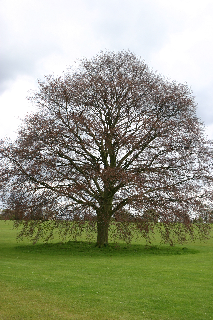

In [ ]:
images_dir = "MSRC_ObjCategImageDatabase_v1"

images_paths = {}
for fn in listdir(images_dir):
  if "_GT" not in fn:
    if fn[0] in images_paths:
      images_paths[fn[0]].append(join(images_dir, fn))
    else:
      images_paths[fn[0]] = [join(images_dir, fn)]
images_paths = list(images_paths.values())

fpath = images_paths[0][0]
fimg = imread(fpath)

cv2_imshow(fimg)

This function allows me to print different images in a single row. All pictures can be displayes if they have the same height.

In [ ]:
def show(images):
  cv2_imshow(np.concatenate(images, axis=1))

**bw** is a function that transforms an image encoded in RGB in black and white. I do this 
- creating a new image with width and height equal to the original,
- taking all the values related to the colors of the original image, 
- computing the mean of these, 
- assigning to the mono channel of new image the mean. 

I will use this function because in this way is simpler see from an image what happen and one channel is better to manage rather than three.

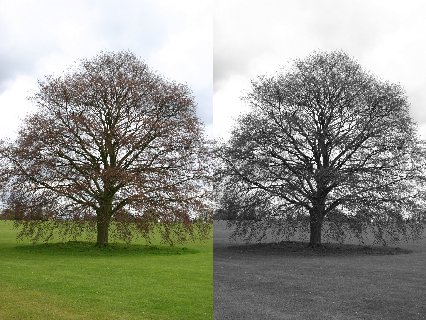

In [ ]:
def bw(img):
  newimg = np.zeros(img.shape)
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      newimg[x,y] = np.mean(img[x, y])
  return newimg

bw_fimg = bw(fimg)

show([fimg, bw_fimg])

At this point I fix two kernels to test the convolution.

In [ ]:
first_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
print(first_kernel)

second_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
print(second_kernel)

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]
[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


**convolve** function takes an image and a kernel and performs the convolution process between them. At the beginning it's created a **padded_img** that is the original image with a padding related to the dimention of the filter. In this way I avoid to produce a convolved image that is smaller than the original. 

The algorithm is able to mantain all the channels of the image, so, if this is encoded in RGB I produce another image with the same encoding.

In the core of this function I 
- take a patch of the image,
- multiply each element of this with the kernel,
- sum all the elements inside of the product.

Under the code of the following function I show the convolved images related to the previous kernels.

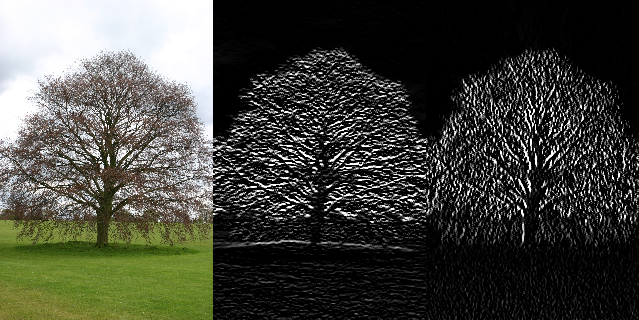

In [ ]:
def convolve(orig_img, kernel):
  (kx, ky) = kernel.shape
  (ix, iy, _) = orig_img.shape
  newimg = np.zeros(orig_img.shape)
  padded_img = np.pad(orig_img, [(kx//2, kx//2+1), (ky//2, ky//2+1), (0,0)], 'edge')
  for x in range(ix):
    for y in range(iy):
      patch = padded_img[x : x+kx, y : y+ky]
      for c in range(3):
        newimg[x, y, c] = np.sum(patch[:,:,c] * kernel)
  return newimg

first_convolved_fimg = convolve(bw_fimg, first_kernel)
second_convolved_fimg = convolve(bw_fimg, second_kernel)

show([fimg, first_convolved_fimg, second_convolved_fimg])

The meshgrids are two matrices composed by 
1. all rows of same vector x,
2. all columns of the same vector y.

Taken the two arguments **w**, x is the vector of values that starts from minus the half of w and goes toward plus the half of w. The same is for **h** related to y.

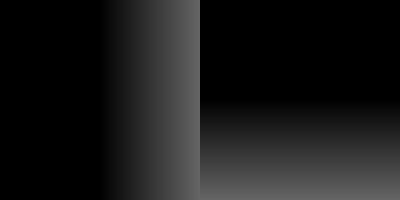

In [ ]:
def create_meshgrids(w, h):
  x = np.linspace(-w//2, w//2+1, w)
  y = np.linspace(-h//2, h//2+1, h)
  return np.meshgrid(x, y)

mg = create_meshgrids(200, 200)
show(mg)

I use the following function to show the 3d plot of the following kernels.

In [ ]:
def show_3d_matrix(X, Y, matrix, title=""):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_title(title)
  ax.plot_surface(X, Y, matrix)
  plt.show()

**gaussian** is the function used to create the gaussian kernel. 

Under the following code I can see the gaussian filter convolved with an image. The effect produced is blurry. Increasing the size of sigma also the effect increase.

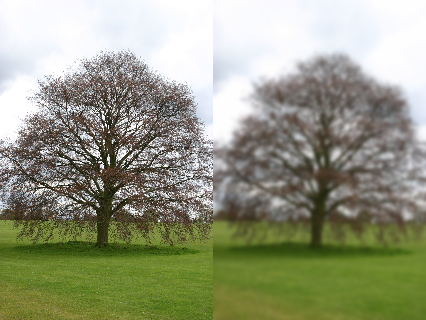

In [ ]:
def gaussian(sigma, meshgrid):
  X, Y = meshgrid
  m = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
  return m / np.sum(m[:])

mg = create_meshgrids(20, 20)
gaussian_kernel = gaussian(2, mg)
gaussian_fimg = convolve(fimg, gaussian_kernel)

show([fimg, gaussian_fimg])

This plot is related to a gaussian kernel with sigma equal to 20.

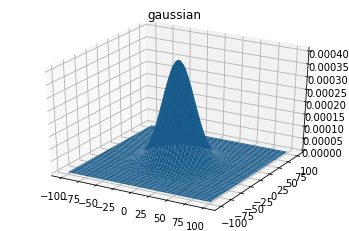

In [ ]:
(X, Y) = create_meshgrids(200, 200)
gk = gaussian(20, (X, Y))

show_3d_matrix(X, Y, gk, "gaussian")

**LoG** function creates the Laplacian of Gaussian filter according to the passed sigma and meshgrids. This is the second derivative of gaussian function.

The convolution applied between an image and this kernel produces another picture where I can find in white the blobs detected.

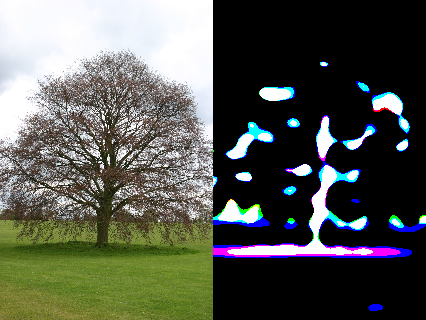

In [ ]:
def LoG(sigma, meshgrids):
  X, Y = meshgrids
  rescaling = sigma**2
  first_term = (-1 / np.pi * sigma**4)
  second_term = (1 - (X**2 + Y**2) / (2 * sigma**2))
  third_term = gaussian(sigma, meshgrids)
  return rescaling * first_term * second_term * third_term

mg = create_meshgrids(40, 40)
LoG_kernel = LoG(8, mg)
LoG_fimg = convolve(fimg, LoG_kernel)

show([fimg, LoG_fimg])

This plot is related to a LoG kernel with sigma equal to 20.

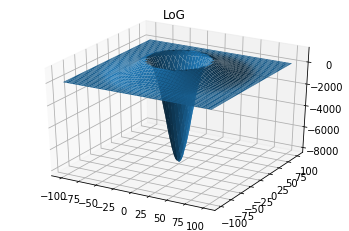

In [ ]:
(X, Y) = create_meshgrids(200, 200)
logk = LoG(20, (X, Y))

show_3d_matrix(X, Y, logk, "LoG")

## Analysis

Fixing 
- meshgrids, 
- sigma_0, 
- K (related to the maximum number of sigma to apply to our images)
- images_limit (number of different images to analyze)

I print all generated sigma.

In [ ]:
mg = create_meshgrids(40, 40)
sigma_0 = 2
K = 4
images_limit = 4

sigmas = [k * sigma_0 for k in range(1, K + 1)]

print("sigmas:", sigmas)


sigmas: [2, 4, 6, 8]


Now I show the LoG filters in 3d plots.

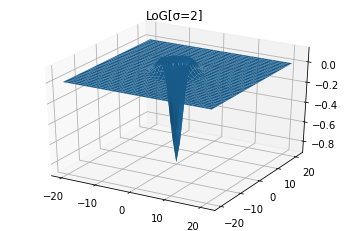

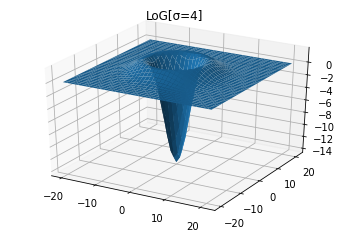

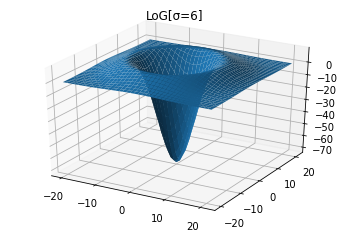

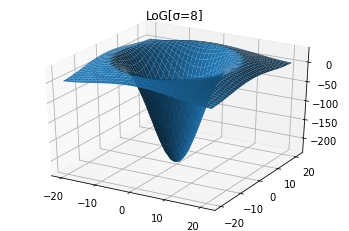

In [ ]:
X, Y = mg
for sigma in sigmas:
  show_3d_matrix(X, Y, LoG(sigma, mg), f"LoG[\u03C3={sigma}]")

I apply LoG filter to *images_limit* pictures rescaling sigma *K* times starting from *sigma_0*.

1	MSRC_ObjCategImageDatabase_v1/2_17_s.bmp


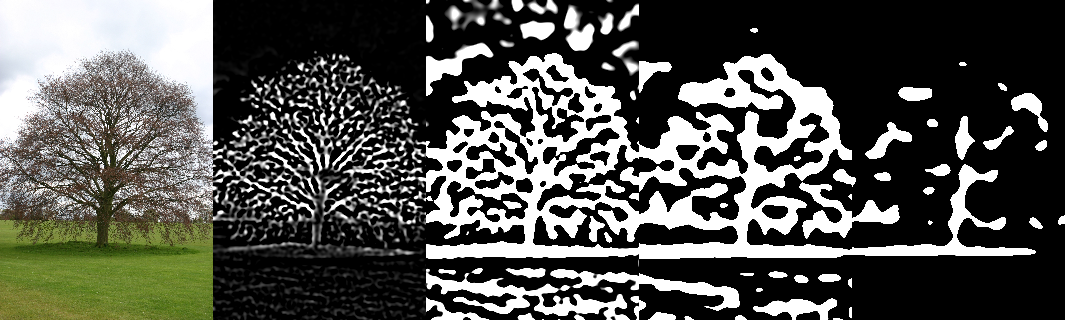

2	MSRC_ObjCategImageDatabase_v1/4_29_s.bmp


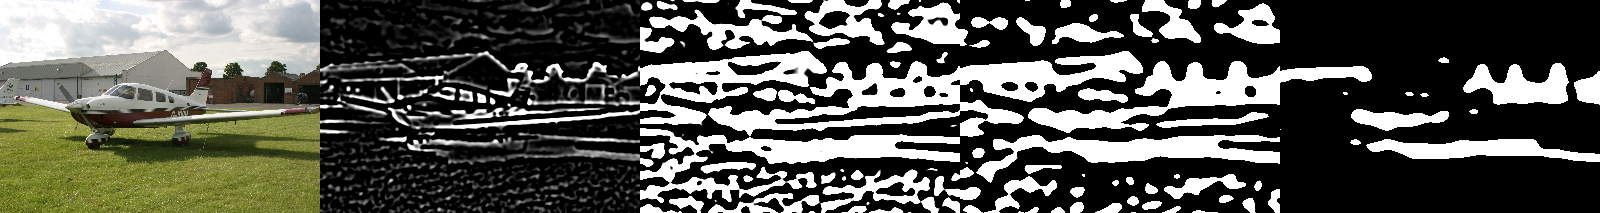

3	MSRC_ObjCategImageDatabase_v1/7_19_s.bmp


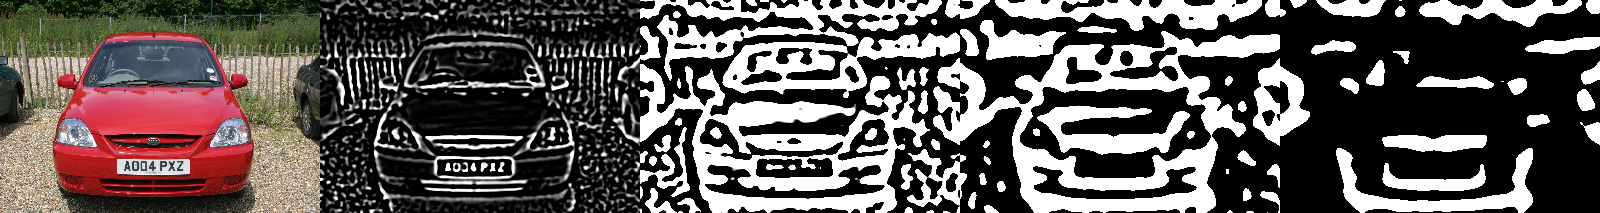

4	MSRC_ObjCategImageDatabase_v1/6_22_s.bmp


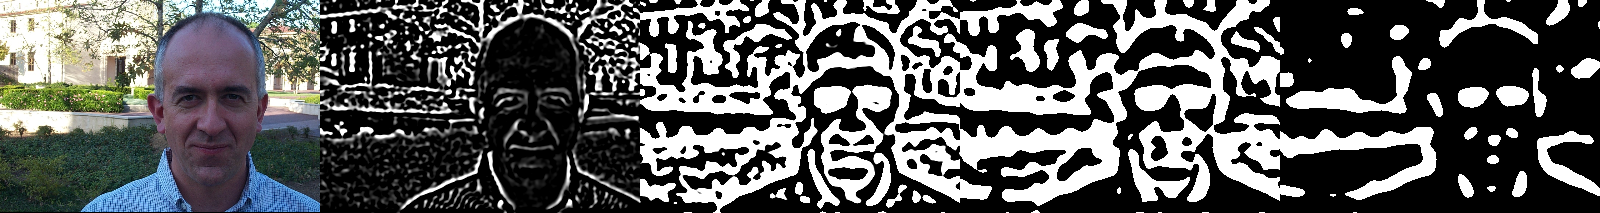

In [ ]:
for i, thematic_class in enumerate(images_paths[:images_limit]):
  path = thematic_class[0]
  print(i+1, path, sep="\t")
  img = imread(path)
  bw_img = bw(img)
  images = [convolve(bw_img, LoG(sigma, mg)) for sigma in sigmas]
  show([img] + images)

Applying the LoG detector to the previous images I can see that increasing sigma the pictures become more approximated. In fact with sigma_0 I can see the edges of the pictures in white while with higher value the figure is vanished in the dark and remain only white points.

This behavior is natural because having a small sigma I detect small points, so I detect more and in the images appear more lines composed by these small spots. In the other case points detected are bigger, so they are rarer.

## Conclusions
LoG is **invariant to scale**; in fact applying the convolution with this filter for different sigma I find different spots with different radius.

Unfortunatelly Laplacian of Gaussian filter is not invariant to the **affine transformations**. It is able to detect only cyrcular points and not ellipsis.

Playing with the params of the filter and images already detected inside the folder I have tried to compare these with the image produced by the convolution. I have found that some comparisons pritty similar.

1	MSRC_ObjCategImageDatabase_v1/8_7_s.bmp


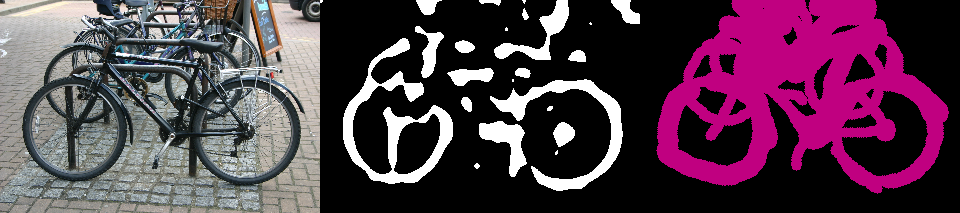

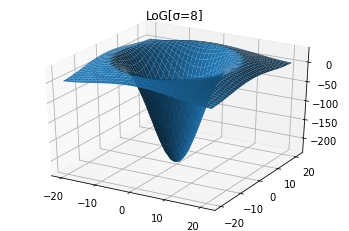

2	MSRC_ObjCategImageDatabase_v1/1_10_s.bmp


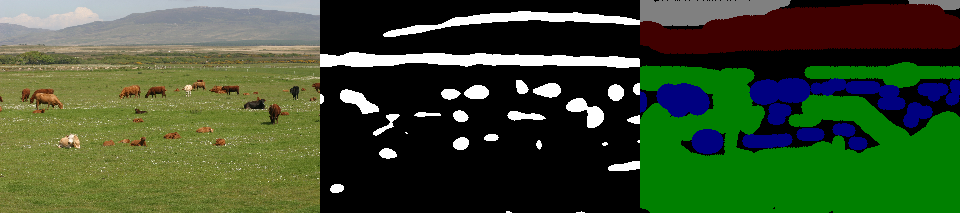

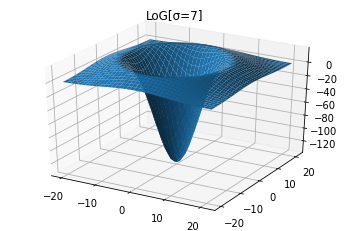

3	MSRC_ObjCategImageDatabase_v1/2_6_s.bmp


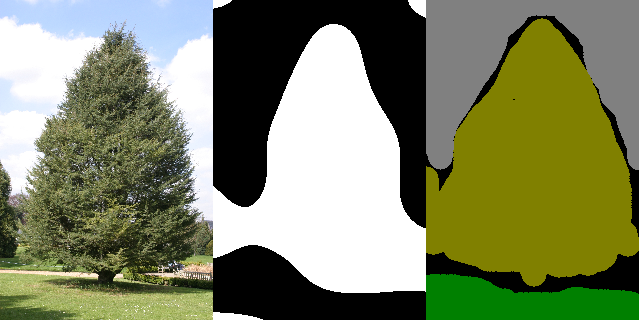

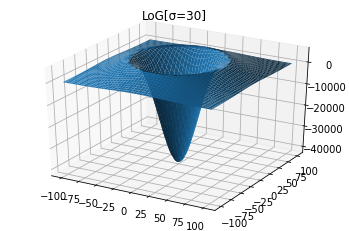

In [ ]:
def compare_images(path, sigma, r):
  compare_path = f"{path[:-4]}_GT.{path[-3:]}"
  img = imread(path)
  cimg = imread(compare_path)
  (X, Y) = create_meshgrids(r, r)
  kernel = LoG(sigma, (X, Y))
  limg = convolve(bw(img), kernel)
  show([img, limg, cimg])
  show_3d_matrix(X, Y, kernel, f"LoG[\u03C3={sigma}]")

items = [
         (images_paths[5][1], 8, 40),
         (images_paths[7][0], 7, 40),
         (images_paths[0][1], 30, 200),
         ]

for i, (path, sigma, r) in enumerate(items):
  print(i+1, path, sep="\t")
  compare_images(path, sigma, r)


It's curious that applying LoG filter to human face the main features appears in white. In fact the kernel is able to detect eyes and face shape (with lower sigma also nose and mouth).

1	MSRC_ObjCategImageDatabase_v1/6_22_s.bmp


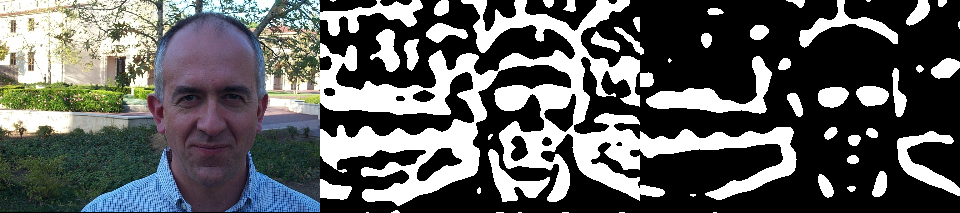

2	MSRC_ObjCategImageDatabase_v1/6_30_s.bmp


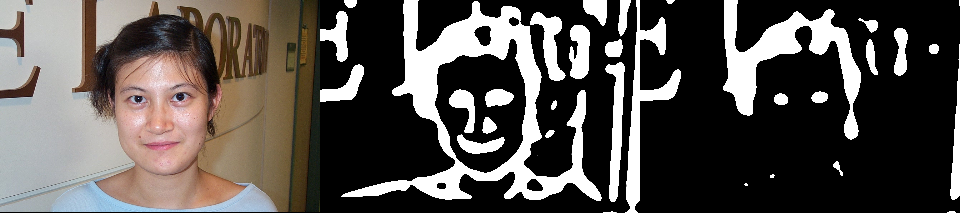

3	MSRC_ObjCategImageDatabase_v1/6_23_s.bmp


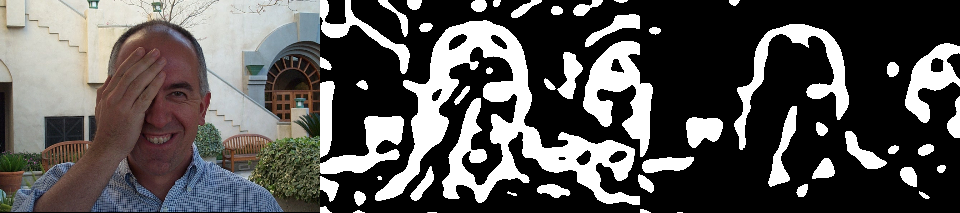

4	MSRC_ObjCategImageDatabase_v1/6_17_s.bmp


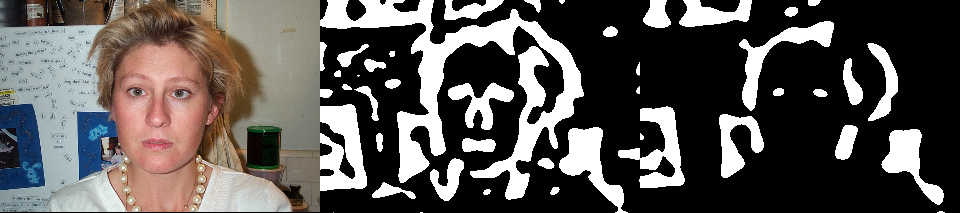

In [ ]:
mg = create_meshgrids(40, 40)
images_limit = 4
sigmas = [6, 8]

for i, path in enumerate(images_paths[3][:images_limit]):
  print(i+1, path, sep="\t")
  img = imread(path)
  bw_img = bw(img)
  images = [convolve(bw_img, LoG(sigma, mg)) for sigma in sigmas]
  show([img] + images)